<a href="https://colab.research.google.com/github/RakshithSuresh/ML-Projects/blob/main/cohort_and_survival_analysis(MK).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np

In [54]:
# reading data
df = pd.read_csv('realistic_readmission_data_v2.csv')
df.head()

,patient_id,condition,admission_date,discharge_date,readmitted_within_90d,readmission_date,followup_received,followup_date,days_to_readmission
0,1,Diabetes,2022-04-13,2022-04-18,0,NaN,0,NaN,NaN
1,2,Heart Failure,2022-07-08,2022-07-14,1,2022-10-01,1,2022-07-18,79.0
2,3,COPD,2022-03-29,2022-04-04,0,NaN,0,NaN,NaN
3,4,Diabetes,2022-05-30,2022-06-05,0,NaN,0,NaN,NaN
4,5,Diabetes,2022-10-21,2022-10-24,0,NaN,1,2022-10-30,NaN


In [55]:
# Summary stats
total_patients = df['patient_id'].nunique()
readmission_rate = df['readmitted_within_90d'].mean()
avg_days_to_readmission = df['days_to_readmission'].mean()
followup_rate = df['followup_received'].mean()

summary_stats = {
    "Total Patients": total_patients,
    "Overall Readmission Rate": f"{readmission_rate:.2%}",
    "Average Days to Readmission": f"{avg_days_to_readmission:.1f}",
    "Follow-up Received Rate": f"{followup_rate:.2%}"
}
print(summary_stats)

{'Total Patients': 1000, 'Overall Readmission Rate': '22.10%', 'Average Days to Readmission': '47.0', 'Follow-up Received Rate': '69.00%'}


In [56]:
# Group by condition
readmit_by_condition = df.groupby('condition')['readmitted_within_90d'].agg(['count', 'sum'])
readmit_by_condition['readmission_rate'] = (readmit_by_condition['sum'] / readmit_by_condition['count']) * 100
readmit_by_condition = readmit_by_condition.rename(columns={'count': 'Patients', 'sum': 'Readmissions'})

# Group by follow-up
readmit_by_followup = df.groupby('followup_received')['readmitted_within_90d'].agg(['count', 'sum'])
readmit_by_followup['readmission_rate'] = (readmit_by_followup['sum'] / readmit_by_followup['count']) * 100
readmit_by_followup = readmit_by_followup.rename(columns={'count': 'Patients', 'sum': 'Readmissions'})

In [57]:
readmit_by_followup

,Patients,Readmissions,readmission_rate
followup_received,,,
0,310,92,29.677419
1,690,129,18.695652


In [58]:
readmit_by_condition

,Patients,Readmissions,readmission_rate
condition,,,
COPD,346,88,25.433526
Diabetes,334,58,17.365269
Heart Failure,320,75,23.437500


/tmp/ipython-input-1474820685.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


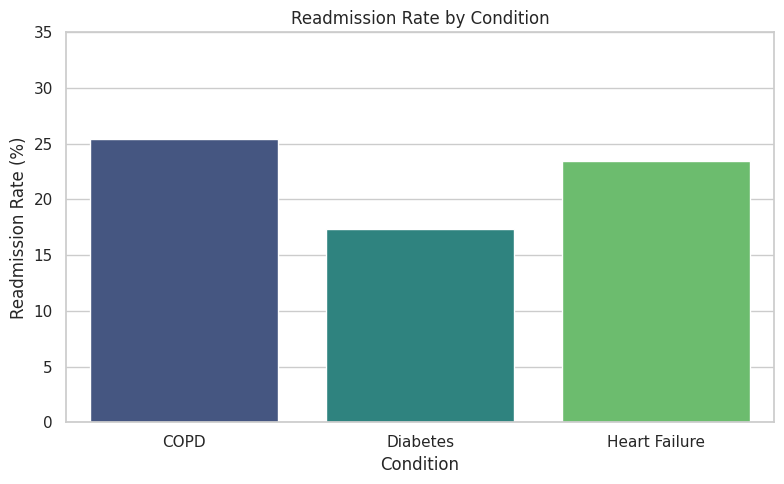

/tmp/ipython-input-1474820685.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


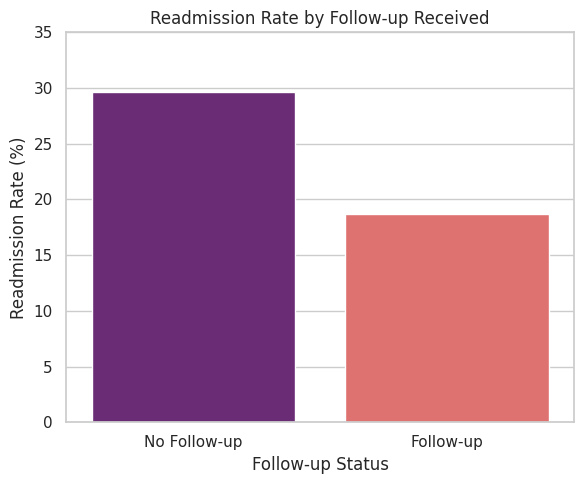

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Plot 1: By condition
plt.figure(figsize=(8, 5))
sns.barplot(
    data=readmit_by_condition.reset_index(),
    x="condition",
    y="readmission_rate",
    palette="viridis"
)
plt.title("Readmission Rate by Condition")
plt.ylabel("Readmission Rate (%)")
plt.xlabel("Condition")
plt.ylim(0, 35)
plt.tight_layout()
plt.show()

# Plot 2: By follow-up
followup_plot_df = readmit_by_followup.reset_index()
followup_plot_df["followup_received"] = followup_plot_df["followup_received"].map({0: "No Follow-up", 1: "Follow-up"})

plt.figure(figsize=(6, 5))
sns.barplot(
    data=followup_plot_df,
    x="followup_received",
    y="readmission_rate",
    palette="magma"
)
plt.title("Readmission Rate by Follow-up Received")
plt.ylabel("Readmission Rate (%)")
plt.xlabel("Follow-up Status")
plt.ylim(0, 35)
plt.tight_layout()
plt.show()


# Phase 2

In [60]:
# Create a new column called 'cohort_name' combining condition and follow-up status
df["cohort_name"] = df.apply(
    lambda row: f"{row['condition']} + {'Follow-up' if row['followup_received'] else 'No Follow-up'}",
    axis=1
)

# See how many patients belong to each cohort
cohort_counts = df["cohort_name"].value_counts().reset_index()
cohort_counts.columns = ["Cohort", "Patient Count"]

print(cohort_counts)

                         Cohort  Patient Count
0     Heart Failure + Follow-up            251
1          Diabetes + Follow-up            222
2              COPD + Follow-up            217
3           COPD + No Follow-up            129
4       Diabetes + No Follow-up            112
5  Heart Failure + No Follow-up             69


In [61]:
pip install lifelines


In [62]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Initialize survival time (duration) and event (readmission)
df['duration'] = df['days_to_readmission']
df['event'] = df['readmitted_within_90d']

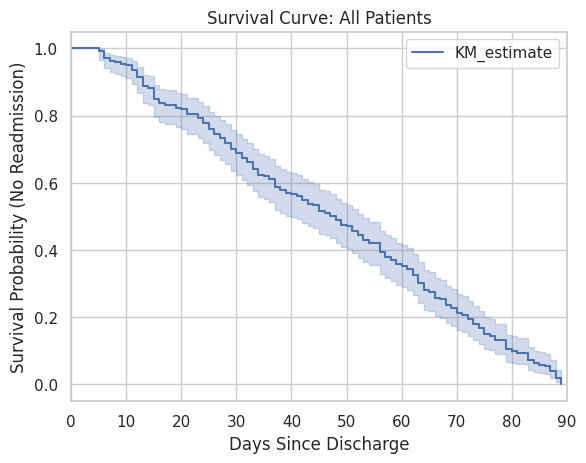

In [63]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Drop rows with missing values in duration or event
km_data = df[['duration', 'event']].dropna()

# Initialize and fit the Kaplan-Meier model
kmf = KaplanMeierFitter()
kmf.fit(durations=km_data['duration'], event_observed=km_data['event'])

# Plot the survival function
kmf.plot_survival_function()
plt.title("Survival Curve: All Patients")
plt.xlabel("Days Since Discharge")
plt.ylabel("Survival Probability (No Readmission)")
plt.xlim(0, 90)
plt.grid(True)
plt.show()


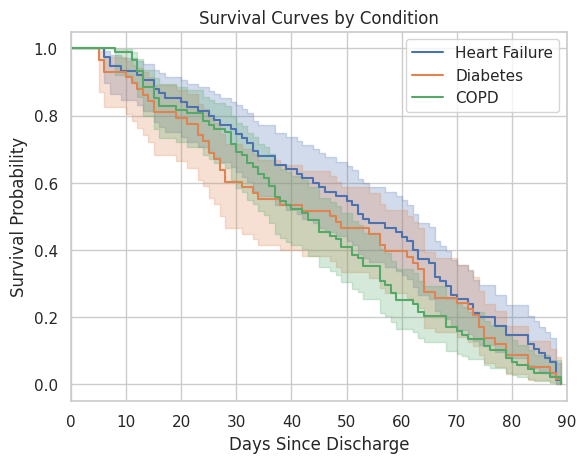

In [64]:
from lifelines import KaplanMeierFitter

# Drop NaNs just once
clean_df = df[['duration', 'event', 'condition']].dropna()

# Create survival curves by condition
for cond in clean_df['condition'].unique():
    kmf = KaplanMeierFitter()
    group = clean_df[clean_df['condition'] == cond]
    kmf.fit(group['duration'], event_observed=group['event'], label=cond)
    kmf.plot_survival_function()

plt.title("Survival Curves by Condition")
plt.xlabel("Days Since Discharge")
plt.ylabel("Survival Probability")
plt.xlim(0, 90)
plt.grid(True)
plt.show()


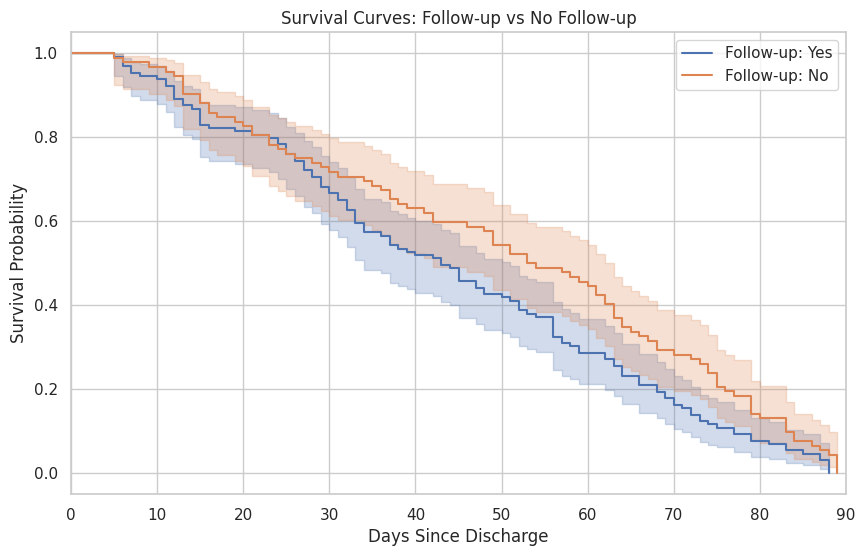

In [65]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Drop NaNs
clean_followup = df[['duration', 'event', 'followup_received']].dropna()

# Convert followup_received to string labels if 0/1
clean_followup['followup_received'] = clean_followup['followup_received'].map({1: 'Yes', 0: 'No'})

# Make sure duration and event are numeric
clean_followup['duration'] = pd.to_numeric(clean_followup['duration'], errors='coerce')
clean_followup['event'] = pd.to_numeric(clean_followup['event'], errors='coerce')

# Drop rows with NaNs in key columns
clean_followup = clean_followup.dropna(subset=['duration', 'event'])

# Plot Kaplan-Meier curves by follow-up status
plt.figure(figsize=(10, 6))
for followup in ['Yes', 'No']:
    kmf = KaplanMeierFitter()
    group = clean_followup[clean_followup['followup_received'] == followup]
    if not group.empty:
        kmf.fit(durations=group['duration'], event_observed=group['event'], label=f'Follow-up: {followup}')
        kmf.plot_survival_function()

plt.title("Survival Curves: Follow-up vs No Follow-up")
plt.xlabel("Days Since Discharge")
plt.ylabel("Survival Probability")
plt.xlim(0, 90)
plt.grid(True)
plt.show()


In [66]:
# Check how many records are in each follow-up group
print(clean_followup['followup_received'].value_counts())

# Check for missing or weird values
print(clean_followup['followup_received'].unique())


followup_received
Yes    129
No      92
Name: count, dtype: int64
['Yes' 'No']


In [67]:
from lifelines.statistics import logrank_test

group_yes = clean_followup[clean_followup['followup_received'] == 'Yes']
group_no = clean_followup[clean_followup['followup_received'] == 'No']

results = logrank_test(
    group_yes['duration'], group_no['duration'],
    event_observed_A=group_yes['event'],
    event_observed_B=group_no['event']
)
results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.39 0.02      5.62

# Phase 3